In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm
from PlotTools import plot_tools as PT

from SoilTools import Hutton as HU
from SoilTools import Hollis as HO

from matplotlib.pyplot import rcParams
%matplotlib inline
rcParams['figure.figsize'] = (12,12)


In [2]:
CM=PT.custom_div_cmap(numcolors=15,name='grad',colors=['blue','yellow','red'])

In [3]:
SOIL_DIR='/prj/GREENHOUSE/SOIL_PROPERTIES/datasets/'
EnW_DIR=SOIL_DIR+'England_Wales_Soil_Data/LDE16_12_SRUC_Tarsitano/' 

EnW_file=EnW_DIR+'EnW_Soil_WeightedCompositionProperties_CHESSgrid.nc'

Scot_file=SOIL_DIR+'Scotland_Soil_Data/' + \
            'Scot_Soil_WeightedCompositionProperties_CHESSgrid.nc'

#COMP_appendfile=SOIL_DIR+'Merged_Soil_WeightedComposition_CHESSgrid.nc'

CHESS_landcover_file='/users/eow/edwcom/CHESS/chess_landcover_2000.nc'

Hyd_LUT_file=EnW_DIR+'Tabular Attribute Data/HORIZONhydraulics_V2.csv'
Cst_LUT_file=EnW_DIR+'Tabular Attribute Data/HORIZONfundamentals_V2.csv'

LatLon_file='/users/eow/edwcom/CHESS/chess_landcover_2000.nc'

OUTFILE=SOIL_DIR+'EnW_Soil_WeightedComposition_CHESSgrid.nc'

fill_value=-9999.0

fill_value=-9999.
Soil_Layer_Thick=np.array([0.1,0.25,0.65,2.0])   #(metres)
Soil_Layer_Depth=np.array([0.1,0.23,1.0,3.0]) #(metres)
nSD=len(Soil_Layer_Thick)


In [4]:
#print(Cst_LUT_file)
#Read in Cst-LUT
Cst_LUT_lines=[line[:-1] for line in open(Cst_LUT_file).readlines()]
Hyd_LUT_lines=[line[:-1] for line in open(Hyd_LUT_file).readlines()]

print(Cst_LUT_lines[0])
print(Hyd_LUT_lines[0])

Cst_headers=Cst_LUT_lines.pop(0).split(',')
Hyd_headers=Hyd_LUT_lines.pop(0).split(',')

print('Cst_Headers = ',Cst_headers)
print('Hyd_Headers = ',Hyd_headers)

LUT_Dict={hdr:[] for hdr in Cst_headers+Hyd_headers}

for Cst_line,Hyd_line in zip(Cst_LUT_lines,Hyd_LUT_lines):
    Cst_vals=Cst_line.split(',')
    Hyd_vals=Hyd_line.split(',')
    # Unless there are values for sand, silt, clay, OC and ph, throw line away
    if (Cst_vals[7]!='')&(Cst_vals[11]!='')&(Cst_vals[12]!='')&(Cst_vals[13]!='')&(Cst_vals[14]!='')\
            &(Hyd_vals[7]!=''):
        # Append Constituents to relevant list
        for hdr,val in zip(Cst_headers,Cst_vals):
            if val=='':
                val='-1'
            LUT_Dict[hdr].append(val)
        # Append Hydraulics to list (missing out the series names and ids etc.)
        for hdr,val in zip(Hyd_headers[7:],Hyd_vals[7:]):
            if val=='':
                val='-1'
            LUT_Dict[hdr].append(val)

    

HORID,SERIES,SERIES_NAME,LU_GROUP,DESIGNATION,UPPER_DEPTH,LOWER_DEPTH,SAND_TOTAL,SAND_FINE,SAND_MED,SAND_COARSE,SILT,CLAY,OC,PH,SAND_TOTAL_QA,SAND_FINE_QA,SAND_MED_QA,SAND_COARSE_QA,SILT_QA,CLAY_QA,OC_QA,PH_QA
HORID,SERIES,SERIES_NAME,LU_GROUP,DESIGNATION,UPPER_DEPTH,LOWER_DEPTH,BULK_DENSITY,PARTICLE_DENSITY,TOTAL_POROSITY,THV0,THV1,THV5,THV10,THV40,THV200,THV1500,KSAT_SUBVERT,KSAT_LAT,VG_TH_S,VG_TH_R,VG_ALPHA,VG_N,VG_M,BC_TH_S,BC_ALPHA,BC_BETA
Cst_Headers =  ['HORID', 'SERIES', 'SERIES_NAME', 'LU_GROUP', 'DESIGNATION', 'UPPER_DEPTH', 'LOWER_DEPTH', 'SAND_TOTAL', 'SAND_FINE', 'SAND_MED', 'SAND_COARSE', 'SILT', 'CLAY', 'OC', 'PH', 'SAND_TOTAL_QA', 'SAND_FINE_QA', 'SAND_MED_QA', 'SAND_COARSE_QA', 'SILT_QA', 'CLAY_QA', 'OC_QA', 'PH_QA']
Hyd_Headers =  ['HORID', 'SERIES', 'SERIES_NAME', 'LU_GROUP', 'DESIGNATION', 'UPPER_DEPTH', 'LOWER_DEPTH', 'BULK_DENSITY', 'PARTICLE_DENSITY', 'TOTAL_POROSITY', 'THV0', 'THV1', 'THV5', 'THV10', 'THV40', 'THV200', 'THV1500', 'KSAT_SUBVERT', 'KSAT_LAT', 'VG_

In [62]:

headers_work=['UPPER_DEPTH', 'LOWER_DEPTH', 'SAND_TOTAL', \
              'SILT', 'CLAY', 'OC', 'PH', \
              'BULK_DENSITY', \
             'SAND_FINE', 'SAND_MED', 'SAND_COARSE',]
                  #, 'PARTICLE_DENSITY', 'TOTAL_POROSITY', \
                  #'SAND_FINE', 'SAND_MED', 'SAND_COARSE', \
                  #'THV0', 'THV1', 'THV5', 'THV10', 'THV40', 'THV200', 'THV1500', \
                  #'KSAT_SUBVERT', 'KSAT_LAT', \
                  #'VG_TH_S', 'VG_TH_R', 'VG_ALPHA', 'VG_N', 'VG_M', \
                  #'BC_TH_S', 'BC_ALPHA', 'BC_BETA', \
                  #]
Data_Dict={}
for hdr in headers_work:
    Data_Dict[hdr]=[float(val) for val in LUT_Dict[hdr]]

for hdr in Data_Dict:
    Data_Dict[hdr]=np.array(Data_Dict[hdr])
    
Data_Dict['MEAN_DEPTH']=(Data_Dict['LOWER_DEPTH']+Data_Dict['UPPER_DEPTH'])/200.
    

In [63]:
#np.where(Data_Dict['SAND_TOTAL']+Data_Dict['SILT']+Data_Dict['CLAY']>102)

print(np.max(Data_Dict['OC']))

43.0


In [64]:
DataFrame=pd.DataFrame(Data_Dict)
print(DataFrame.columns)

Index(['BULK_DENSITY', 'CLAY', 'LOWER_DEPTH', 'MEAN_DEPTH', 'OC', 'PH',
       'SAND_COARSE', 'SAND_FINE', 'SAND_MED', 'SAND_TOTAL', 'SILT',
       'UPPER_DEPTH'],
      dtype='object')


In [65]:
BULK_DENSITY_HUTTON=HU.bulk_density(DataFrame['OC'], \
                                    DataFrame['CLAY'], \
                                    DataFrame['SILT'], )

In [66]:
BULK_DENSITY_HOLLIS=HO.Cult_TopSoil_BD(DataFrame['OC'], \
                                       DataFrame['SAND_TOTAL'], \
                                       DataFrame['CLAY'], )
                                    

In [67]:

DataFrame['log_OC']=np.log(DataFrame['OC'])
DataFrame['exp_OC']=np.exp(DataFrame['OC'])
DataFrame['sq_OC']=DataFrame['OC']**2
DataFrame['cu_OC']=DataFrame['OC']**3
DataFrame['sq_UPPER_DEPTH']=DataFrame['UPPER_DEPTH']**2
DataFrame['sqrt_UPPER_DEPTH']=DataFrame['UPPER_DEPTH']**0.5
DataFrame['log_UPPER_DEPTH']=np.log(DataFrame['UPPER_DEPTH'])
DataFrame['exp_UPPER_DEPTH']=np.exp(DataFrame['UPPER_DEPTH'])


In [68]:
#model=ols("BULK_DENSITY ~ OC + log_OC + sq_OC + SILT + CLAY + SAND_TOTAL",DataFrame).fit()

#model=ols("BULK_DENSITY ~ OC + log_OC + sq_OC  +SILT + CLAY",DataFrame).fit()
model=ols("BULK_DENSITY ~ log_OC + OC",DataFrame).fit()

In [69]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           BULK_DENSITY   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 2.130e+04
Date:                Wed, 07 Sep 2016   Prob (F-statistic):               0.00
Time:                        15:55:41   Log-Likelihood:                 7290.5
No. Observations:                5976   AIC:                        -1.458e+04
Df Residuals:                    5973   BIC:                        -1.455e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.3341      0.001    986.492      0.0

In [70]:
Bulk_Density_Model = model.params['Intercept'] 
for param in model.params.index:
    if param!='Intercept':
        Bulk_Density_Model+= DataFrame[param]*model.params[param]

In [85]:
BULK_DENSITY_ECOSSE=1.772-0.4127*np.log(DataFrame['OC'])

(-0.1, 2.0)

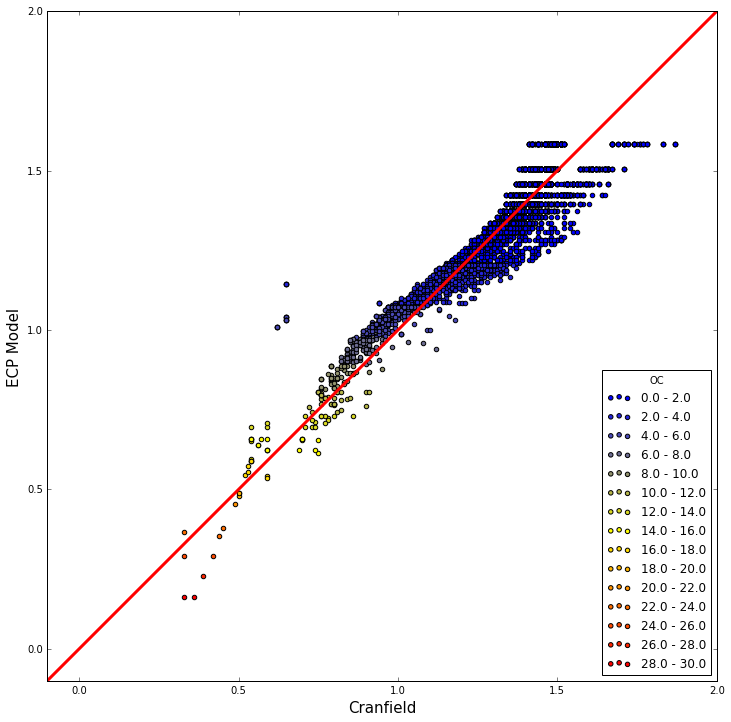

In [71]:
cbar_param='OC'
interval=2.
data1,name1=DataFrame['BULK_DENSITY'],'Cranfield'
data2,name2=Bulk_Density_Model,'ECP Model'

for i in range(15):#,0,-1):
    index=(DataFrame[cbar_param]>(float(i)*interval)-0.01)&\
          (DataFrame[cbar_param]<((float(i)*interval)+interval))
    plt.scatter(data1[index],data2[index],c=CM(i),\
                label=str(float(i)*interval)+' - '+str((float(i)*interval)+interval) )

plt.legend(loc='lower right',title=cbar_param)
plt.plot([-0.5,2],[-0.5,2],c='r',lw=3)
plt.xlabel(name1,fontsize=15)
plt.ylabel(name2,fontsize=15)
plt.ylim([-0.1,2.])
plt.xlim([-0.1,2.])

In [72]:
DataFrame.columns

Index(['BULK_DENSITY', 'CLAY', 'LOWER_DEPTH', 'MEAN_DEPTH', 'OC', 'PH',
       'SAND_COARSE', 'SAND_FINE', 'SAND_MED', 'SAND_TOTAL', 'SILT',
       'UPPER_DEPTH', 'log_OC', 'exp_OC', 'sq_OC', 'cu_OC', 'sq_UPPER_DEPTH',
       'sqrt_UPPER_DEPTH', 'log_UPPER_DEPTH', 'exp_UPPER_DEPTH'],
      dtype='object')

(-0.1, 2.0)

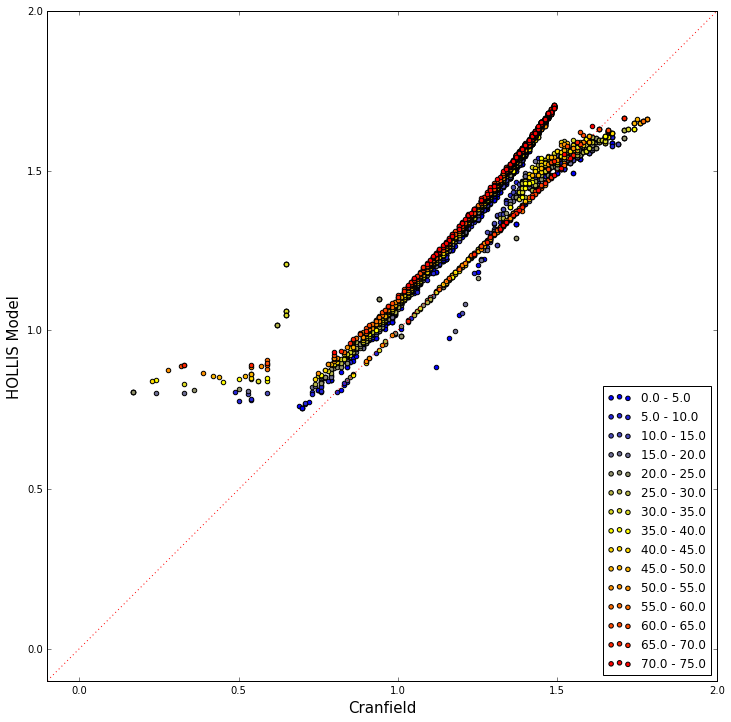

In [83]:
param='SAND_TOTAL'
interval=5
data1,name1=DataFrame['BULK_DENSITY'],'Cranfield'
data2,name2=BULK_DENSITY_HOLLIS,'HOLLIS Model'

for i in range(15):
    index=(DataFrame[param]>(float(i)*interval-0.01))&\
          (DataFrame[param]<((float(i)*interval)+interval-0.01))
    plt.scatter(data1[index],data2[index],c=CM(i),\
                label=str(float(i)*interval)+' - '+str((float(i)*interval)+interval) )

plt.legend(loc='lower right')
plt.plot([-0.5,2],[-0.5,2],c='r',lw=1,ls=':')
plt.xlabel(name1,fontsize=15)
plt.ylabel(name2,fontsize=15)
plt.ylim([-0.1,2.])
plt.xlim([-0.1,2.])

(-0.1, 2.0)

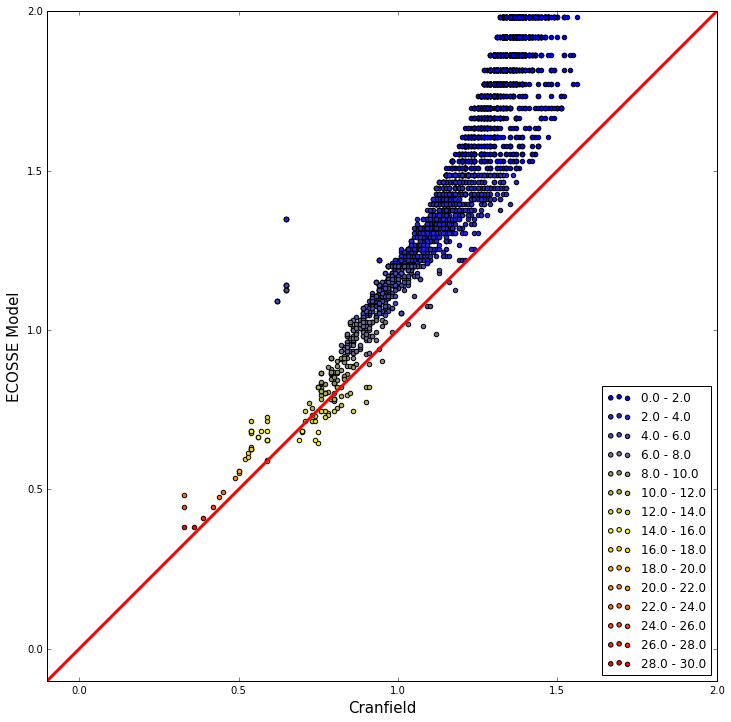

In [86]:
param='OC'
interval=2.
data1,name1=DataFrame['BULK_DENSITY'],'Cranfield'
data2,name2=BULK_DENSITY_ECOSSE,'ECOSSE Model'

for i in range(15):
    index=(DataFrame[param]>(float(i)*interval-0.01))&\
          (DataFrame[param]<((float(i)*interval)+interval-0.01))
    plt.scatter(data1[index],data2[index],c=CM(i),\
                label=str(float(i)*interval)+' - '+str((float(i)*interval)+interval) )

plt.legend(loc='lower right')
plt.plot([-0.5,2],[-0.5,2],c='r',lw=3)
plt.xlabel(name1,fontsize=15)
plt.ylabel(name2,fontsize=15)
plt.ylim([-0.1,2.])
plt.xlim([-0.1,2.])

In [22]:
param='org_carb'
interval=2.
data1,name1=EnW_datadict['Bulk_Density'],'Cranfield'
data2,name2=BULK_DENSITY_HUTTON,'HUTTON Model'

for i in range(15):
    index=(EnW_datadict[param]>(float(i)*interval))&\
          (EnW_datadict[param]<((float(i)*interval)+interval))
    plt.scatter(data1[index],data2[index],c=CM(i),\
                label=str(float(i)*interval)+' - '+str((float(i)*interval)+interval) )

plt.legend(loc='lower right')
plt.plot([-0.5,2],[-0.5,2],c='r',lw=3)
plt.xlabel(name1,fontsize=15)
plt.ylabel(name2,fontsize=15)
plt.ylim([-0.1,2])
plt.xlim([-0.1,2])

NameError: name 'EnW_datadict' is not defined

In [ ]:
# Use model parameters to calculate Scotish Bulk Density
Scot_datadict['sq_org_carb']=Scot_datadict['org_carb']**2
Scot_datadict['log_org_carb']=np.log(Scot_datadict['org_carb'])

Scot_datadict['Bulk_Density'] = model.params['Intercept'] 
for param in model.params.index:
    if param!='Intercept':
        Scot_datadict['Bulk_Density']+= Scot_datadict[param]*model.params[param]
    


In [ ]:
print(Scot_datadict['Bulk_Density'].shape)
print(np.min(Scot_datadict['Bulk_Density']))

hist_data=Scot_datadict['Bulk_Density']
plt.hist(hist_data[hist_data.mask==False],bins=50) #np.arange(0,15.6,1.))
plt.show()

plt.scatter(Scot_datadict['Bulk_Density'],Scot_datadict['org_carb'])
plt.ylabel('org_carb')
plt.xlabel('Bulk_Density')
plt.show()

plt.imshow(Scot_datadict['Bulk_Density'],origin='bottom')
plt.colorbar()

In [ ]:
EnWinf=nc.Dataset(EnW_file,'r')
Scotinf=nc.Dataset(Scot_file,'a')

outvar=Scotinf.createVariable()

Scotinf.close()
